In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
%matplotlib inline

In [2]:
PATH = 'all.csv'

# 1. Chargement des données

***

In [3]:
sp = pd.read_csv(PATH, sep = '\t')

In [4]:
sp.shape

(671, 12)

In [5]:
sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         671 non-null    object
 1   artist        671 non-null    object
 2   release       671 non-null    object
 3   bpm           671 non-null    int64 
 4   energy        671 non-null    int64 
 5   danceability  671 non-null    int64 
 6   loud          671 non-null    int64 
 7   valence       671 non-null    int64 
 8   length        671 non-null    object
 9   acoustic      671 non-null    int64 
 10  popularity    671 non-null    int64 
 11  style         671 non-null    object
dtypes: int64(7), object(5)
memory usage: 63.0+ KB


In [6]:
sp.head()

,title,artist,release,bpm,energy,danceability,loud,valence,length,acoustic,popularity,style
0,Don't Let Me Down,The Chainsmokers,5/02/16,160,87,53,-5,42,03:28,16,84,POP
1,In the Name of Love,Martin Garrix,29/07/16,134,52,50,-6,17,03:16,11,83,POP
2,FRIENDS,Marshmello,9/02/18,95,88,63,-2,53,03:23,21,90,POP
3,The Middle,Zedd,23/01/18,107,65,75,-3,43,03:05,21,54,POP
4,Never Forget You,Zara Larsson,10/09/15,146,73,58,-6,28,03:33,0,22,POP


# 2. Préparation des données

***

## 2.1 Minutes en secondes

Comme nous l'avions déjà fait précédemment, nous transformons nos minutes en secondes.

In [7]:
def minutes_to_seconds(m):
    m, s = m.split(':')
    return int(m) * 60 + int(s)

In [8]:
sp['seconds'] = sp['length'].apply(minutes_to_seconds)

## 2.2 Transformer les types de chansons en dummy variables 

Cette fois-ci, nous allons créer quelque chose de légèrement différent : des dummy variables. Dans le monde du développement, nous les connaissons sous un autre nom : variables booléennes.

Dans ce cas, le type de chanson est ici codé en tant que chaîne de caractères. Dans une régression, ce type de variable ne peut être traité... sauf si on les transforme en dummy variables. 

### 2.2.1 Exemple de dummy variables (avec l'aide d'un fichier de données factice)

Regardons cela de plus près :

In [9]:
PATH_DUMMIES = 'futur_dummies.csv'

In [10]:
futur_dummies = pd.read_csv(PATH_DUMMIES, sep =';')

In [11]:
futur_dummies

,music,review
0,Pressure,Cool
1,Breaking the habit,Cool
2,Radioactive,Neutral
3,Umbrella,Not my style
4,Maniacs,Cool


Comme vous pouvez le voir, la colonne review est ici en chaîne de caractères. Pour la transformer en valeurs booléennes, nous allons utiliser la fonction **get_dummies** de pandas.

In [12]:
review_dummies = pd.get_dummies(futur_dummies['review'], prefix='review_')

In [13]:
review_dummies

,review__Cool,review__Neutral,review__Not my style
0,1,0,0
1,1,0,0
2,0,1,0
3,0,0,1
4,1,0,0


Comprenons ensemble ses paramètres :
1. on lui envoie notre colonne codée en string ;
2. on supprime une des valeurs booléennes pour éviter la **multicolinéarité** (d'où le **drop_first**) ;
3. on ajoute un préfixe aux nouvelles colonnes créées.

Dorénavant, il suffit de concaténer nos deux DataFrame : 

In [14]:
new_data_frame_with_dummies = pd.concat([futur_dummies, review_dummies], axis = 1)

In [15]:
new_data_frame_with_dummies

,music,review,review__Cool,review__Neutral,review__Not my style
0,Pressure,Cool,1,0,0
1,Breaking the habit,Cool,1,0,0
2,Radioactive,Neutral,0,1,0
3,Umbrella,Not my style,0,0,1
4,Maniacs,Cool,1,0,0


### 2.2.2 Cas réel avec les styles de musiques

De retour dans le monde musical, il est évident que la colonne à traiter est "**style**".

In [16]:
style_dummies = pd.get_dummies(sp['style'], drop_first=True, prefix='style_')

In [17]:
sp = pd.concat([sp, style_dummies], axis = 1)

In [18]:
sp.head()

,title,artist,release,bpm,energy,danceability,loud,valence,length,acoustic,...,style,seconds,style__DECENNIES,style__DEEP FOCUS,style__FUNK,style__JAZZ,style__POP,style__RAP,style__ROCK,style__VIRAL
0,Don't Let Me Down,The Chainsmokers,5/02/16,160,87,53,-5,42,03:28,16,...,POP,208,0,0,0,0,1,0,0,0
1,In the Name of Love,Martin Garrix,29/07/16,134,52,50,-6,17,03:16,11,...,POP,196,0,0,0,0,1,0,0,0
2,FRIENDS,Marshmello,9/02/18,95,88,63,-2,53,03:23,21,...,POP,203,0,0,0,0,1,0,0,0
3,The Middle,Zedd,23/01/18,107,65,75,-3,43,03:05,21,...,POP,185,0,0,0,0,1,0,0,0
4,Never Forget You,Zara Larsson,10/09/15,146,73,58,-6,28,03:33,0,...,POP,213,0,0,0,0,1,0,0,0


# 3. Mesurer la corrélation des données

***

Créons une nouvelle variable qui va contenir toutes nos corrélations :

In [19]:
corr = sp.corr()
corr

,bpm,energy,danceability,loud,valence,acoustic,popularity,seconds,style__DECENNIES,style__DEEP FOCUS,style__FUNK,style__JAZZ,style__POP,style__RAP,style__ROCK,style__VIRAL
bpm,1.000000,0.215457,-0.044197,0.221465,0.059033,-0.205205,0.039030,0.009886,0.156748,-0.111602,-0.077219,-0.113506,-0.087929,0.144051,0.050132,0.068870
energy,0.215457,1.000000,0.290425,0.859697,0.566727,-0.784217,-0.078099,-0.133740,0.297820,-0.541634,0.264846,-0.502930,0.048756,-0.018972,0.249387,-0.003539
danceability,-0.044197,0.290425,1.000000,0.410181,0.546807,-0.312721,0.187963,-0.121361,-0.006835,-0.452482,0.319175,-0.168708,0.209671,0.352435,-0.257163,0.122521
loud,0.221465,0.859697,0.410181,1.000000,0.537600,-0.775279,0.077684,-0.183956,0.216724,-0.609291,0.154595,-0.492701,0.182254,0.093626,0.227653,0.066482
valence,0.059033,0.566727,0.546807,0.537600,1.000000,-0.415209,-0.100679,-0.068028,0.116092,-0.557281,0.440402,-0.143832,0.022315,0.004281,0.005520,-0.028591
acoustic,-0.205205,-0.784217,-0.312721,-0.775279,-0.415209,1.000000,0.006883,0.191318,-0.242938,0.477324,-0.168437,0.543506,-0.117705,-0.098137,-0.274452,0.053436
popularity,0.039030,-0.078099,0.187963,0.077684,-0.100679,0.006883,1.000000,-0.138843,0.079895,0.008627,-0.385040,-0.146916,0.227955,0.340449,-0.293726,0.236382
seconds,0.009886,-0.133740,-0.121361,-0.183956,-0.068028,0.191318,-0.138843,1.000000,-0.000158,-0.046261,0.072755,0.438045,-0.112892,-0.129727,-0.117019,0.021830
style__DECENNIES,0.156748,0.297820,-0.006835,0.216724,0.116092,-0.242938,0.079895,-0.000158,1.000000,-0.166366,-0.175397,-0.151122,-0.157081,-0.125648,-0.201385,-0.087110
style__DEEP FOCUS,-0.111602,-0.541634,-0.452482,-0.609291,-0.557281,0.477324,0.008627,-0.046261,-0.166366,1.000000,-0.148819,-0.128222,-0.133278,-0.106608,-0.170868,-0.073910


Le résultat n'est pas très visuel. Faisons appel à seaborn :

<AxesSubplot:>

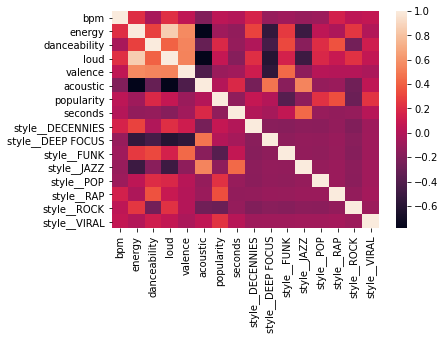

In [20]:
sns.heatmap(corr)

In [21]:
corr['danceability'].sort_values()

style__DEEP FOCUS   -0.452482
acoustic            -0.312721
style__ROCK         -0.257163
style__JAZZ         -0.168708
seconds             -0.121361
bpm                 -0.044197
style__DECENNIES    -0.006835
style__VIRAL         0.122521
popularity           0.187963
style__POP           0.209671
energy               0.290425
style__FUNK          0.319175
style__RAP           0.352435
loud                 0.410181
valence              0.546807
danceability         1.000000
Name: danceability, dtype: float64

# 4. Préparation des features et de target

***

In [22]:
# nous mélangeons les indices aléatoirement
indices = np.random.permutation(sp.index)
length_data = sp.shape[0]
# on sélectionne 80% des indices
limit_train = int(length_data * 0.80)
# on sélectionne 80% des données
train = sp.iloc[:limit_train]
# on sélectionne les 20% restant
test = sp.iloc[limit_train:]

In [23]:
# on sélectionne le nom des colonnes qui commencent par notre préfixe 'style_'
styles = [name for name in sp.columns if name.startswith('style_')]
styles

['style__DECENNIES',
 'style__DEEP FOCUS',
 'style__FUNK',
 'style__JAZZ',
 'style__POP',
 'style__RAP',
 'style__ROCK',
 'style__VIRAL']

In [24]:
all_features = ['bpm', 'acoustic', 'energy', 'loud', 'valence', 'popularity', 'seconds'] + styles
# on crée nos données initiales : le nom de y ainsi que ses données
name_target = 'danceability'
target = train[name_target]

# 5. Préparation de nos fonctions utilitaires

***

Dans le cas où vous auriez oublié la signification des formules, n'hésitez pas à consulter les diapositives du cours.

In [25]:
# voir slides concernant la régression linéaire
    
def compute_residuals(yactuals, ypred):
    return (yactuals - ypred)

In [26]:
# voir slides concernant la régression linéaire

def r_squared(yactuals, ypred):
    sst = ((yactuals - yactuals.mean()) ** 2).sum()
    sse = ((yactuals - ypred) ** 2).sum()
    
    return 1 - (sse / sst)

In [27]:
# voir slides concernant la régression linéaire

def r_squared_adjusted(yactuals, ypred, n_features):
    r_s = r_squared(yactuals, ypred)
    n = yactuals.shape[0]
    return 1 - (1 - r_s) * ((n - 1) / (n - n_features - 1))

# 6. À la recherche des features optimales

***

Au lieu de chercher manuellement qu'elles sont les meilleurs features, nous pouvons utiliser la technique du RFECV. Cela signifie :
- **R**ecursive
- **F**eature
- **E**limination
- **C**ross
- **V**alidation

En résumé, cette manière de procéder teste toute une série de modèles pour *in fine* supprimer les features les plus inutiles.

## 6.1 Sa création

Quelques paramètres lui seront nécessaires :
1. **estimator** : un modèle vierge
2. **step** : le nombre de paramètres qu'il supprimera à chaque tour de boucle
3. **cv** : une instance de KFold
4. **scoring** : la métrique qu'il va générer à chaque tour de boucle

In [28]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
rfecv = RFECV(LinearRegression(), step=1, cv=kfold, scoring='neg_mean_squared_error')

## 6.2 Son entrainement

Tout comme les modèles vus précédemment, on les entraine en faisant appel à leur méthode *fit*.

Avant cela, créons des variables qui vont contenir nos variables explicatives (X) et notre variable à expliquer (y).

In [29]:
X = sp[all_features]
y = sp[name_target]

In [30]:
rfecv.fit(X, y)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
      estimator=LinearRegression(), scoring='neg_mean_squared_error')

## 6.3 Son attribut *support_*

Juste après avoir exécuté la méthode *fit*, son attribut *support_* a été initialisé. Celui-ci contient un tableau de booléens. Ceux-ci indiquent quels sont les features à garder ou non.

In [31]:
rfecv.support_

array([ True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True])

En soi, cette variable n'est pas très parlante. Mettons côte à côte nos features et l'attribut *support_*.

In [32]:
features_and_support = pd.concat([pd.Series(all_features), pd.Series(rfecv.support_)], axis=1)
features_and_support

,0,1
0,bpm,True
1,acoustic,True
2,energy,True
3,loud,True
4,valence,True
5,popularity,False
6,seconds,False
7,style__DECENNIES,True
8,style__DEEP FOCUS,True
9,style__FUNK,True


Grâce à cette petite manipulation, nous remarquons que : *popularity* et *seconds* ne sont pas nécessaires à notre modèle.

Il est essentiel de stocker les features importantes dans une variable :

In [33]:
important_features = features_and_support[features_and_support.iloc[:, 1]].iloc[:, 0]
important_features

0                   bpm
1              acoustic
2                energy
3                  loud
4               valence
7      style__DECENNIES
8     style__DEEP FOCUS
9           style__FUNK
10          style__JAZZ
11           style__POP
12           style__RAP
13          style__ROCK
14         style__VIRAL
Name: 0, dtype: object

# 7. Création de notre régression linéaire

In [34]:
# on crée notre modèle
lr = LinearRegression()
# on l'entraîne
lr.fit(train[important_features], train[name_target])
# on prédit les valeurs
yhat = lr.predict(test[important_features])
# on réalise quelques mesures :
print("R squared (sklearn):", r2_score(test[name_target], yhat))
print("R squared (manual):", r_squared(test[name_target], yhat))
print("Adjusted R squared:", r_squared_adjusted(test[name_target], yhat, important_features.shape[0]))

R squared (sklearn): 0.3397183396656823
R squared (manual): 0.3397183396656823
Adjusted R squared: 0.2687789877289374


Nous pouvons également consulter notre RMSE (Root Mean Squared Error) :

In [35]:
mses = cross_val_score(LinearRegression(), 
                        sp[important_features], sp[name_target], 
                        cv=kfold, scoring='neg_mean_squared_error')
mean_mse = -np.mean(mses)
rmse = mean_mse ** 0.5
print(rmse)

10.979473072289581
